<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/Milestone_Project_1_Food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 1: Food Vision Big

In [1]:
##Use Tensorflow Dataset to Download the Data
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset_list = tfds.list_builders()
print('food101' in dataset_list)

True


In [3]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, ##data get returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete80RXFR/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete80RXFR/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpx2wt08v8tfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

###Exploring food101 data for Tensorflow Dataset

* Class names
* The shapes of our input data
* The datatype of our input data
* What our labels looks like (is it one-hot encoded)

In [5]:
## 1. Getting the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
len(class_names)

101

In [7]:
## 2. Shapes of our input data
train_data_one_sample = train_data.take(1) ##Samples are in format (image_tensor, label)
train_data_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Image label: 30


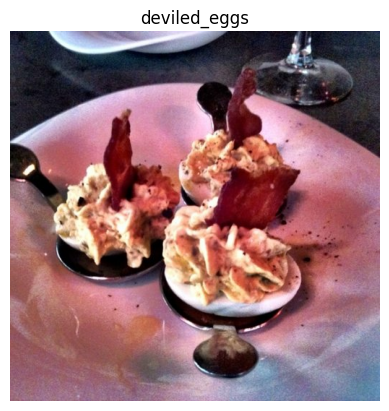

In [8]:
import matplotlib.pyplot as plt
for image, label in train_data_one_sample:
  print("Image shape:",image.shape)
  print("Image datatype:",image.dtype)
  print('Image label:', label.numpy())
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
array([[[28, 31, 50],
        [27, 30, 49],
        [21, 23, 44],
        ...,
        [17, 28, 60],
        [20, 30, 65],
        [28, 38, 73]],

       [[11, 14, 33],
        [23, 26, 45],
        [24, 26, 47],
        ...,
        [39, 50, 82],
        [33, 44, 76],
        [19, 30, 62]]], dtype=uint8)>

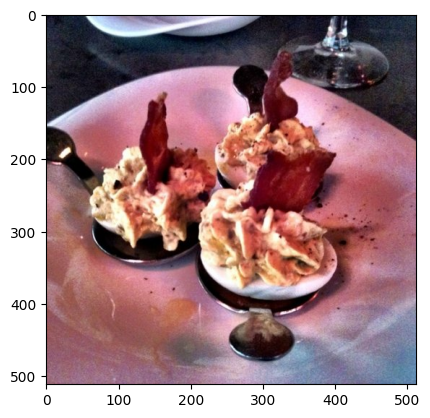

In [9]:
plt.imshow(image)
image[:2]

In [10]:
## What are the min and max of our image tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

###Encoding and ploting the images

(512, 512, 3)
<dtype: 'float32'>


(-0.5, 511.5, 511.5, -0.5)

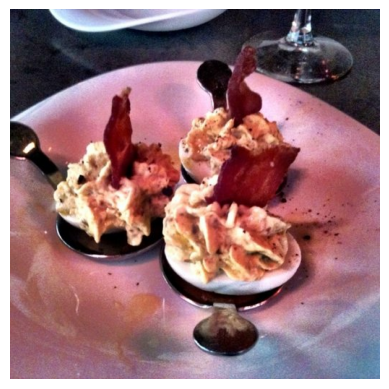

In [11]:
encoded_image = image/255
print(encoded_image.shape)
print(encoded_image.dtype)
plt.imshow(encoded_image)
plt.axis(False)

In [12]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

###Create Prepreocessing function for our data
Nueral network performs best when data is in the form of tensors, and batchs and in normalized form

* So we can create a preprocessing function and map it to our dataset


 What we know about our data?
* In `utf8` datatype
* Comprised of all differect size tensors(different sized images)
* Not scaled (the poxel values are between 0 & 255)


 What models like?
* Data in `float32` dtype (or for mixed pricision `float32` and `float16`)
* Scaled (values between 0 & 1)


In [13]:
def preprocess_image(image, label, image_shape=224):
  """
  converts image datatype from 'utf8' -> 'floadt32' and reshapes
  image to [image_shape, image_shape, color_channel]
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  image = image/255
  return tf.cast(image, dtype=tf.float32), label

In [14]:
## Preprocess simgle image with the help of preprocess_image() function

preprocessed_image, label = preprocess_image(image, label)

In [15]:
print(preprocessed_image.shape)
print(preprocessed_image.dtype)

(224, 224, 3)
<dtype: 'float32'>


### Batch and Prepare Dataset making then run faster

In [16]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
## Mapping preprocess_image() function to training (and parallelize)
train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
## shuffle train_data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000) ## how many to shuffle at a time
train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Doing the same steps to our test_data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

##Creating Model callback
* Create model checkpoint callback

In [19]:
checkpoint_path = 'ModelCheckpoint/TL_project_1.ckpt'
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_best_only=True,
                                                     monitor='val_acc',
                                                     save_weights_only=True,
                                                     save_freq='epoch')

###Setting up Mixed-Precision training

the computation will be done on `float16` but the variable are store in `float32` so we have to store the values in `float32`.

**`numerical stebility`**

In [20]:
import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [21]:
## Creating a model
def create_feature_extraction_model():
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable=False

  input = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
  ##Note: The EfficientNetB0 model has built in rescaling layer so we don't need the rescaling layer for EfficientNetB0 model
  ##x = tf.keras.preprocessing.Rescaling(1/255.)

  x = base_model(input, training=False)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  output = tf.keras.layers.Dense(101, activation='softmax', dtype='float32', name='output_layer')(x)

  model = tf.keras.Model(input, output)

  return model

In [22]:
model_01 = create_feature_extraction_model()

16705208/16705208 [==============================] - 0s 0us/step


In [23]:
model_01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [24]:
## Info about the model
for layer in model_01.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [25]:
## More Info about the base model
for layer in model_01.layers[1].layers[:15]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">


In [26]:
model_01.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_01 = model_01.fit(train_data,
                          epochs=3,
                          validation_data=test_data,
                          validation_steps=int(0.1 * len(test_data)),
                          callbacks=[modelcheckpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 4.7002 - accuracy: 0.0095

2368/2368 [==============================] - 210s 80ms/step - loss: 4.7002 - accuracy: 0.0095 - val_loss: 4.6982 - val_accuracy: 0.0075
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 4.6924 - accuracy: 0.0105

2368/2368 [==============================] - 189s 79ms/step - loss: 4.6924 - accuracy: 0.0105 - val_loss: 4.7245 - val_accuracy: 0.0103
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 4.6871 - accuracy: 0.0105

2368/2368 [==============================] - 176s 73ms/step - loss: 4.6871 - accuracy: 0.0105 - val_loss: 4.6739 - val_accuracy: 0.0079


In [27]:
##Evaluate the model with whole test data
model_01.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 4.6812 - accuracy: 0.0103


[4.681196689605713, 0.01029702927917242]